# BPE Токенизатор

In [2]:
import re
import json
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Set, Optional
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import os
import glob

# Для графиков на русском
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Реализация BPE Токенизатора

### Паттерн претокенизации

Используем паттерн претокенизации из GPT-4 (cl100k_base), который хорошо работает с многоязычными текстами:

**Источник:** OpenAI tiktoken library - https://github.com/openai/tiktoken

Паттерн разделяет текст на:
- Апострофные сокращения (английские)
- Буквенные последовательности (включая Unicode)
- Числа
- Пробелы (группами)
- Остальные символы

In [2]:
class BPETokenizer:
    """
    BPE (Byte Pair Encoding) токенизатор с претокенизацией и специальными токенами.
    """
    
    PRETOKENIZE_PATTERN = re.compile(
        r"""'(?i:[sdmt]|ll|ve|re)"""  # Английские сокращения с апострофом
        r"""|[^\r\n\W\d]?[^\W\d]+"""  # Буквенные последовательности (Unicode) - заменено \p{L}
        r"""|\d{1,3}"""  # Числа (группы до 3 цифр) - заменено \p{N}
        r"""| ?[^\s\w]+[\r\n]*"""  # Пунктуация и спецсимволы - заменено \p{L}\p{N}
        r"""|\s*[\r\n]"""  # Переводы строк
        r"""|\s+(?!\S)"""  # Пробелы в конце
        r"""|\s+""",  # Пробелы
        re.VERBOSE | re.UNICODE
    )
    
    def __init__(self, vocab_size: int = 10000, special_tokens: List[str] = None):
        """
        Инициализация токенизатора.
        
        Args:
            vocab_size: Желаемый размер словаря
            special_tokens: Список специальных токенов
        """
        self.vocab_size = vocab_size
        
        if special_tokens is None:
            special_tokens = ["<PAD>", "<UNK>", "<BOS>", "<EOS>", "<MASK>"]
        self.special_tokens = special_tokens
        
        self.vocab: Dict[str, int] = {}
        self.inverse_vocab: Dict[int, str] = {}
        self.merges: List[Tuple[str, str]] = []
        
        self._init_base_vocab()
        
    def _init_base_vocab(self):
        """Инициализация базового словаря с байтами и специальными токенами."""
        for i, token in enumerate(self.special_tokens):
            self.vocab[token] = i
            self.inverse_vocab[i] = token
        
        offset = len(self.special_tokens)
        for i in range(256):
            byte_token = bytes([i]).decode('latin-1')
            self.vocab[byte_token] = offset + i
            self.inverse_vocab[offset + i] = byte_token
            
    def _pretokenize(self,ext: str) -> List[str]:
        """Претокенизация текста с использованием регулярного выражения."""
        tokens = self.PRETOKENIZE_PATTERN.findall(text)
        if not tokens:
            # Если паттерн не сработал, разбиваем по символам
            tokens = list(text)
        return tokens
    
    def _text_to_bytes(self, text: str) -> List[str]:
        """Преобразование текста в последовательность байтов."""
        return [bytes([b]).decode('latin-1') for b in text.encode('utf-8')]
    
    def _get_pairs(self, tokens: List[str]) -> Counter:
        """Подсчет пар соседних токенов."""
        pairs = Counter()
        for i in range(len(tokens) - 1):
            pairs[(tokens[i], tokens[i + 1])] += 1
        return pairs
    
    def _merge_pair(self, tokens: List[str], pair: Tuple[str, str]) -> List[str]:
        """Слияние всех вхождений пары в списке токенов."""
        new_tokens = []
        i = 0
        while i < len(tokens):
            if i < len(tokens) - 1 and tokens[i] == pair[0] and tokens[i + 1] == pair[1]:
                new_tokens.append(pair[0] + pair[1])
                i += 2
            else:
                new_tokens.append(tokens[i])
                i += 1
        return new_tokens
    
    def train(self, texts: List[str], verbose: bool = True):
        """
        Обучение BPE токенизатора на корпусе текстов.
        
        Args:
            texts
        # Претокенизация и преобразование в байты: Список текстов для обучения
            verbose: Показывать прогресс
        """
        word_freqs = Counter()
        
        if verbose:
            print("Претокенизация и подсчет частот...")
        
        for text in tqdm(texts, disable=not verbose):
            pretokens = self._pretokenize(text)
            for pretoken in pretokens:
                # Преобразуем каждый претокен в байты
                byte_seq = tuple(self._text_to_bytes(pretoken))
                word_freqs[byte_seq] += 1
        
        if verbose:
            print(f"Уникальных претокенов: {len(word_freqs)}")
        
        # Обучение BPE
        num_merges = self.vocab_size - len(self.vocab)
        
        if verbose:
            print(f"Выполняем {num_merges} слияний...")
        
        pbar = tqdm(range(num_merges), disable=not verbose)
        for _ in pbar:
            pair_freqs = Counter()
            for word, freq in word_freqs.items():
                word_list = list(word)
                for i in range(len(word_list) - 1):
                    pair_freqs[(word_list[i], word_list[i + 1])] += freq
            
            if not pair_freqs:
                break
                
            best_pair = pair_freqs.most_common(1)[0][0]
            
            new_token = best_pair[0] + best_pair[1]
            new_id = len(self.vocab)
            self.vocab[new_token] = new_id
            self.inverse_vocab[new_id] = new_token
            self.merges.append(best_pair)
            
            new_word_freqs = Counter()
            for word, freq in word_freqs.items():
                new_word = self._merge_pair(list(word), best_pair)
                new_word_freqs[tuple(new_word)] += freq
            word_freqs = new_word_freqs
            
            pbar.set_description(f"Merged: {best_pair[0]!r} + {best_pair[1]!r}")
        
        if verbose:
            print(f"Финальный размер словаря: {len(self.vocab)}")
    
    def encode(self, text: str, add_special_tokens: bool = False) -> List[int]:
        """
        Кодирование текста в последовательность токенов.
        
        Args:
            text: Входной текст
            add_special_tokens: Добавить BOS/EOS токены
            
        Returns:
            Список ID токенов
        """
        tokens = []
        
        if add_special_tokens:
            tokens.append(self.vocab["<BOS>"])
        
        # Претокенизация
        pretokens = self._pretokenize(text)
        
        for pretoken in pretokens:
            # Преобразуем в байты
            byte_tokens = self._text_to_bytes(pretoken)
            
            # Применяем слияния
            for merge in self.merges:
                byte_tokens = self._merge_pair(byte_tokens, merge)
            
            # Преобразуем в ID
            for token in byte_tokens:
                if token in self.vocab:
                    tokens.append(self.vocab[token])
                else:
                    tokens.append(self.vocab["<UNK>"])
        
        if add_special_tokens:
            tokens.append(self.vocab["<EOS>"])
            
        return tokens
    
    def decode(self, token_ids: List[int]) -> str:
        """
        Декодирование последовательности токенов в текст.
        
        Args:
            token_ids: Список ID токенов
            
        Returns:
            Декодированный текст
        """
        byte_tokens = []
        for token_id in token_ids:
            if token_id in self.inverse_vocab:
                token = self.inverse_vocab[token_id]
                if token not in self.special_tokens:
                    byte_tokens.append(token)
        
        # Собираем байты и декодируем
        byte_string = ''.join(byte_tokens).encode('latin-1')
        return byte_string.decode('utf-8', errors='replace')
    
    def get_vocab_size(self) -> int:
        """Возвращает текущий размер словаря."""
        return len(self.vocab)
    
    def save(self, path: str):
        """Сохранение токенизатора."""
        data = {
            'vocab': self.vocab,
            'merges': self.merges,
            'special_tokens': self.special_tokens
        }
        with open(path, 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
    
    @classmethod
    def load(cls, path: str) -> 'BPETokenizer':
        """Загрузка токенизатора."""
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        tokenizer = cls(vocab_size=len(data['vocab']), special_tokens=data['special_tokens'])
        tokenizer.vocab = data['vocab']
        tokenizer.inverse_vocab = {v: k for k, v in data['vocab'].items()}
        tokenizer.merges = [tuple(m) for m in data['merges']]
        return tokenizer

## 2. Подготовка корпуса для обучения

Создадим разнообразный корпус на русском языке для обучения токенизатора.

In [29]:
training_corpus = [
    # Литературные тексты
    """Все счастливые семьи похожи друг на друга, каждая несчастливая семья несчастлива по-своему.
    Всё смешалось в доме Облонских. Жена узнала, что муж был в связи с бывшею в их доме француженкою-гувернанткой.""",
    
    """В начале июля, в чрезвычайно жаркое время, под вечер, один молодой человек вышел из своей каморки,
    которую нанимал от жильцов в С-м переулке, на улицу и медленно, как бы в нерешимости, отправился к К-ну мосту.""",
    
    """Однажды весною, в час небывало жаркого заката, в Москве, на Патриарших прудах, появились два гражданина.
    Первый из них, одетый в серенькую летнюю пару, был маленького роста, упитан, лыс.""",
    
    # Научные тексты
    """Машинное обучение — это область искусственного интеллекта, которая использует статистические методы
    для обучения компьютерных систем на данных. Нейронные сети представляют собой вычислительные модели,
    вдохновлённые биологическими нейронными сетями головного мозга.""",
    
    """Квантовая механика описывает поведение материи на атомном и субатомном уровнях. Принцип неопределённости
    Гейзенберга утверждает, что невозможно одновременно точно измерить положение и импульс частицы.""",
    
    """Алгоритмы глубокого обучения используют многослойные нейронные сети для извлечения признаков из данных.
    Трансформеры революционизировали обработку естественного языка благодаря механизму внимания.""",
    
    # Новостные тексты
    """Правительство одобрило новый пакет мер по поддержке экономики. Министр финансов заявил, что выделенные
    средства будут направлены на развитие инфраструктуры и поддержку малого бизнеса.""",
    
    """На международной конференции по климату обсуждались вопросы снижения выбросов углекислого газа.
    Представители стран договорились о новых целях по декарбонизации экономики.""",
    
    # Технические тексты
    """Для установки библиотеки используйте команду pip install numpy. Импортируйте модуль с помощью
    import numpy as np. Создание массивов осуществляется функцией np.array().""",
    
    """HTTP-запросы выполняются с помощью библиотеки requests. Метод GET используется для получения данных,
    а метод POST — для отправки данных на сервер. Обработка JSON осуществляется методом response.json().""",
    
    # Разговорная речь
    """Привет! Как дела? Давно не виделись. Может, встретимся в субботу? Погода обещает быть хорошей.
    Можем погулять в парке или посидеть в кафе.""",
    
    """Слушай, я тут подумал насчёт нашего проекта. Может, стоит пересмотреть подход? Мне кажется,
    мы могли бы сделать всё гораздо эффективнее.""",
    
    # Юридические тексты
    """Согласно статье 159 Уголовного кодекса Российской Федерации, мошенничество, то есть хищение чужого
    имущества или приобретение права на чужое имущество путём обмана или злоупотребления доверием.""",
    
    """Договор аренды недвижимого имущества, заключённый на срок более года, подлежит государственной регистрации
    и считается заключённым с момента такой регистрации.""",
    
    # Медицинские тексты
    """Артериальная гипертензия является фактором риска развития сердечно-сосудистых заболеваний.
    Рекомендуется регулярный контроль артериального давления и соблюдение назначенной терапии.""",
    
    """При диагностике заболевания используются лабораторные методы исследования: общий анализ крови,
    биохимический анализ, иммунологические тесты.""",
    
    # Дополнительные тексты для разнообразия
    """Российская Федерация — государство в Восточной Европе и Северной Азии. Столица — Москва.
    Крупнейшие города: Санкт-Петербург, Новосибирск, Екатеринбург, Казань, Нижний Новгород.""",
    
    """Петербургское лето было в разгаре. Белые ночи окутывали город своим призрачным светом.
    Разводные мосты поднимались, пропуская корабли по Неве.""",
    
    """Программирование на Python становится всё более популярным. Язык отличается простым синтаксисом
    и большим количеством библиотек для анализа данных, машинного обучения и веб-разработки.""",
    
    """Современные методы обработки естественного языка позволяют анализировать тексты на различных языках,
    извлекать информацию, классифицировать документы и генерировать ответы на вопросы.""",

    """Математический анализ изучает функции, пределы, производные и интегралы. Дифференциальное исчисление
    занимается изучением скорости изменения величин.""",
    
    """Искусственный интеллект находит применение в различных областях: от распознавания изображений
    до автономного вождения автомобилей.""",
    
    """Экономический рост страны зависит от множества факторов: инвестиций, производительности труда,
    технологического развития и качества человеческого капитала.""",
    
    """Литературный язык — это обработанная форма общенародного языка, обладающая письменно закреплёнными
    нормами и широким диапазоном функциональных стилей.""",
    
    """Астрономия — наука о Вселенной, изучающая расположение, движение, структуру, происхождение и развитие
    небесных тел и систем.""",
]

print(f"Размер обучающего корпуса: {len(training_corpus)} текстов")
print(f"Общее количество символов: {sum(len(t) for t in training_corpus)}")

Размер обучающего корпуса: 25 текстов
Общее количество символов: 4423


## 3. Обучение токенизатора

In [32]:
# Создаём и обучаем токенизатор
tokenizer = BPETokenizer(vocab_size=5000)
tokenizer.train(training_corpus, verbose=True)

Претокенизация и подсчет частот...


100%|██████████| 25/25 [00:00<00:00, 5622.69it/s]


Уникальных претокенов: 454
Выполняем 4739 слияний...


Merged: ' Ñ\x82Ðµ' + 'Ð»':  33%|███▎      | 1581/4739 [00:01<00:02, 1078.04it/s]                                               

Финальный размер словаря: 1842


In [7]:
# Проверка работы токенизатора
test_text = "Привет, мир! Это тестовый текст для проверки токенизатора."

encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)

print(f"Исходный текст: {test_text}")
print(f"Закодированный: {encoded}")
print(f"Количество токенов: {len(encoded)}")
print(f"Декодированный: {decoded}")
print(f"Совпадение: {test_text == decoded}")

Исходный текст: Привет, мир! Это тестовый текст для проверки токенизатора.
Закодированный: [1279, 49, 302, 264, 270, 38, 261, 178, 379, 448, 277, 295, 495, 1657, 277, 433, 344, 295, 298, 360, 543, 466, 310, 279, 332, 501, 51]
Количество токенов: 27
Декодированный: Привет, мир! Это тестовый текст для проверки токенизатора.
Совпадение: True


## 4. Тестовые корпуса для анализа эффективности

Создадим тексты разных доменов, которые **не использовались** при обучении.

In [8]:
test_corpora = {
    "литература": [
        """Выхожу один я на дорогу; Сквозь туман кремнистый путь блестит;
        Ночь тиха. Пустыня внемлет богу, И звезда с звездою говорит.""",
        
        """Я помню чудное мгновенье: Передо мной явилась ты,
        Как мимолётное виденье, Как гений чистой красоты.""",
        
        """Мой дядя самых честных правил, Когда не в шутку занемог,
        Он уважать себя заставил И лучше выдумать не мог.""",
    ],
    
    "наука": [
        """Термодинамика изучает превращение энергии и тепловые процессы в физических системах.
        Первый закон термодинамики утверждает, что энергия не создаётся и не уничтожается.""",
        
        """Молекулярная биология исследует механизмы репликации ДНК и транскрипции генов.
        Рибосомы синтезируют белки на основе информации, закодированной в мРНК.""",
        
        """Электромагнитная индукция возникает при изменении магнитного потока через контур.
        Закон Фарадея определяет величину индуцированной электродвижущей силы.""",
    ],
    
    "новости": [
        """Центральный банк принял решение о снижении ключевой ставки на 0,5 процентных пункта.
        Эксперты прогнозируют положительное влияние на кредитование бизнеса.""",
        
        """На форуме обсуждались перспективы развития возобновляемой энергетики.
        Участники отметили необходимость увеличения инвестиций в солнечную и ветровую генерацию.""",
        
        """Учёные разработали новый метод диагностики заболеваний с использованием
        технологий искусственного интеллекта и анализа медицинских изображений.""",
    ],
    
    "код": [
        """def calculate_fibonacci(n):
            if n <= 1:
                return n
            return calculate_fibonacci(n-1) + calculate_fibonacci(n-2)""",
        
        """class DataProcessor:
            def __init__(self, config):
                self.config = config
            def process(self, data):
                return self.transform(data)""",
        
        """SELECT users.name, orders.total FROM users
        INNER JOIN orders ON users.id = orders.user_id
        WHERE orders.date > '2024-01-01'""",
    ],
    
    "разговорный": [
        """Ну что, как выходные провёл? Я на дачу ездил, шашлыки жарили.
        Погода была супер, загорели даже немного.""",
        
        """Слышал про новый фильм? Говорят, очень крутой! Давай сходим в кино
        на следующей неделе, если будет время.""",
        
        """Представляешь, вчера кота потерял на час. Искал везде, а он в шкафу спрятался.
        Вот хитрец такой!""",
    ],
}

print("Тестовые корпуса подготовлены:")
for domain, texts in test_corpora.items():
    total_chars = sum(len(t) for t in texts)
    print(f"  {domain}: {len(texts)} текстов, {total_chars} символов")

Тестовые корпуса подготовлены:
  литература: 3 текстов, 352 символов
  наука: 3 текстов, 493 символов
  новости: 3 текстов, 478 символов
  код: 3 текстов, 462 символов
  разговорный: 3 текстов, 328 символов


## 5. Анализ эффективности токенизатора

In [10]:
def analyze_tokenization(tokenizer: BPETokenizer, texts: List[str], domain_name: str = "") -> Dict:
    """
    Анализ эффективности токенизации.
    
    Returns:
        Словарь с метриками
    """
    total_tokens = 0
    total_bytes = 0
    total_chars = 0
    total_words = 0
    
    word_tokens = []  # Количество токенов на слово
    word_freqs = Counter()  # Частота слов
    word_to_tokens = {}  # Слово -> количество токенов
    used_tokens = set()  # Использованные токены
    
    for text in texts:
        # Общая статистика
        encoded = tokenizer.encode(text)
        total_tokens += len(encoded)
        total_bytes += len(text.encode('utf-8'))
        total_chars += len(text)
        used_tokens.update(encoded)
        
        # Анализ по словам
        words = re.findall(r'[a-zA-Zа-яА-ЯёЁ]+', text)
        total_words += len(words)
        
        for word in words:
            word_lower = word.lower()
            word_freqs[word_lower] += 1
            
            # Токенизируем слово отдельно
            word_encoded = tokenizer.encode(word)
            n_tokens = len(word_encoded)
            word_tokens.append(n_tokens)
            
            if word_lower not in word_to_tokens:
                word_to_tokens[word_lower] = n_tokens
    
    # Расчёт метрик
    compression_ratio_bytes = total_tokens / total_bytes if total_bytes > 0 else 0
    compression_ratio_chars = total_tokens / total_chars if total_chars > 0 else 0
    avg_tokens_per_word = np.mean(word_tokens) if word_tokens else 0
    
    # Анализ топ-10% частотных слов
    sorted_words = word_freqs.most_common()
    top_10_percent_count = max(1, len(sorted_words) // 10)
    top_words = [w for w, _ in sorted_words[:top_10_percent_count]]
    
    top_word_tokens = [word_to_tokens.get(w, 0) for w in top_words if w in word_to_tokens]
    avg_tokens_top_10 = np.mean(top_word_tokens) if top_word_tokens else 0
    
    results = {
        'domain': domain_name,
        'total_tokens': total_tokens,
        'total_bytes': total_bytes,
        'total_chars': total_chars,
        'total_words': total_words,
        'compression_ratio_bytes': compression_ratio_bytes,
        'compression_ratio_chars': compression_ratio_chars,
        'avg_tokens_per_word': avg_tokens_per_word,
        'avg_tokens_top_10_percent': avg_tokens_top_10,
        'unique_tokens_used': len(used_tokens),
        'used_tokens': used_tokens,
    }
    
    return results

In [12]:
# Анализ эффективности по доменам
domain_results = {}

print("=" * 80)
print("АНАЛИЗ ЭФФЕКТИВНОСТИ ТОКЕНИЗАТОРА ПО ДОМЕНАМ")
print("=" * 80)

for domain, texts in test_corpora.items():
    results = analyze_tokenization(tokenizer, texts, domain)
    domain_results[domain] = results
    
    print(f"\nДомен: {domain.upper()}")
    print("-" * 40)
    print(f"  Всего токенов: {results['total_tokens']}")
    print(f"  Всего байт: {results['total_bytes']}")
    print(f"  Всего символов: {results['total_chars']}")
    print(f"  Всего слов: {results['total_words']}")
    print(f"  Коэффициент сжатия (токены/байты): {results['compression_ratio_bytes']:.4f}")
    print(f"  Коэффициент сжатия (токены/символы): {results['compression_ratio_chars']:.4f}")
    print(f"  Среднее токенов на слово: {results['avg_tokens_per_word']:.2f}")
    print(f"  Среднее токенов на слово (топ 10%): {results['avg_tokens_top_10_percent']:.2f}")

АНАЛИЗ ЭФФЕКТИВНОСТИ ТОКЕНИЗАТОРА ПО ДОМЕНАМ

Домен: ЛИТЕРАТУРА
----------------------------------------
  Всего токенов: 187
  Всего байт: 617
  Всего символов: 352
  Всего слов: 54
  Коэффициент сжатия (токены/байты): 0.3031
  Коэффициент сжатия (токены/символы): 0.5312
  Среднее токенов на слово: 3.17
  Среднее токенов на слово (топ 10%): 1.80

Домен: НАУКА
----------------------------------------
  Всего токенов: 226
  Всего байт: 902
  Всего символов: 493
  Всего слов: 55
  Коэффициент сжатия (токены/байты): 0.2506
  Коэффициент сжатия (токены/символы): 0.4584
  Среднее токенов на слово: 4.55
  Среднее токенов на слово (топ 10%): 3.00

Домен: НОВОСТИ
----------------------------------------
  Всего токенов: 193
  Всего байт: 876
  Всего символов: 478
  Всего слов: 50
  Коэффициент сжатия (токены/байты): 0.2203
  Коэффициент сжатия (токены/символы): 0.4038
  Среднее токенов на слово: 4.60
  Среднее токенов на слово (топ 10%): 3.00

Домен: КОД
---------------------------------------

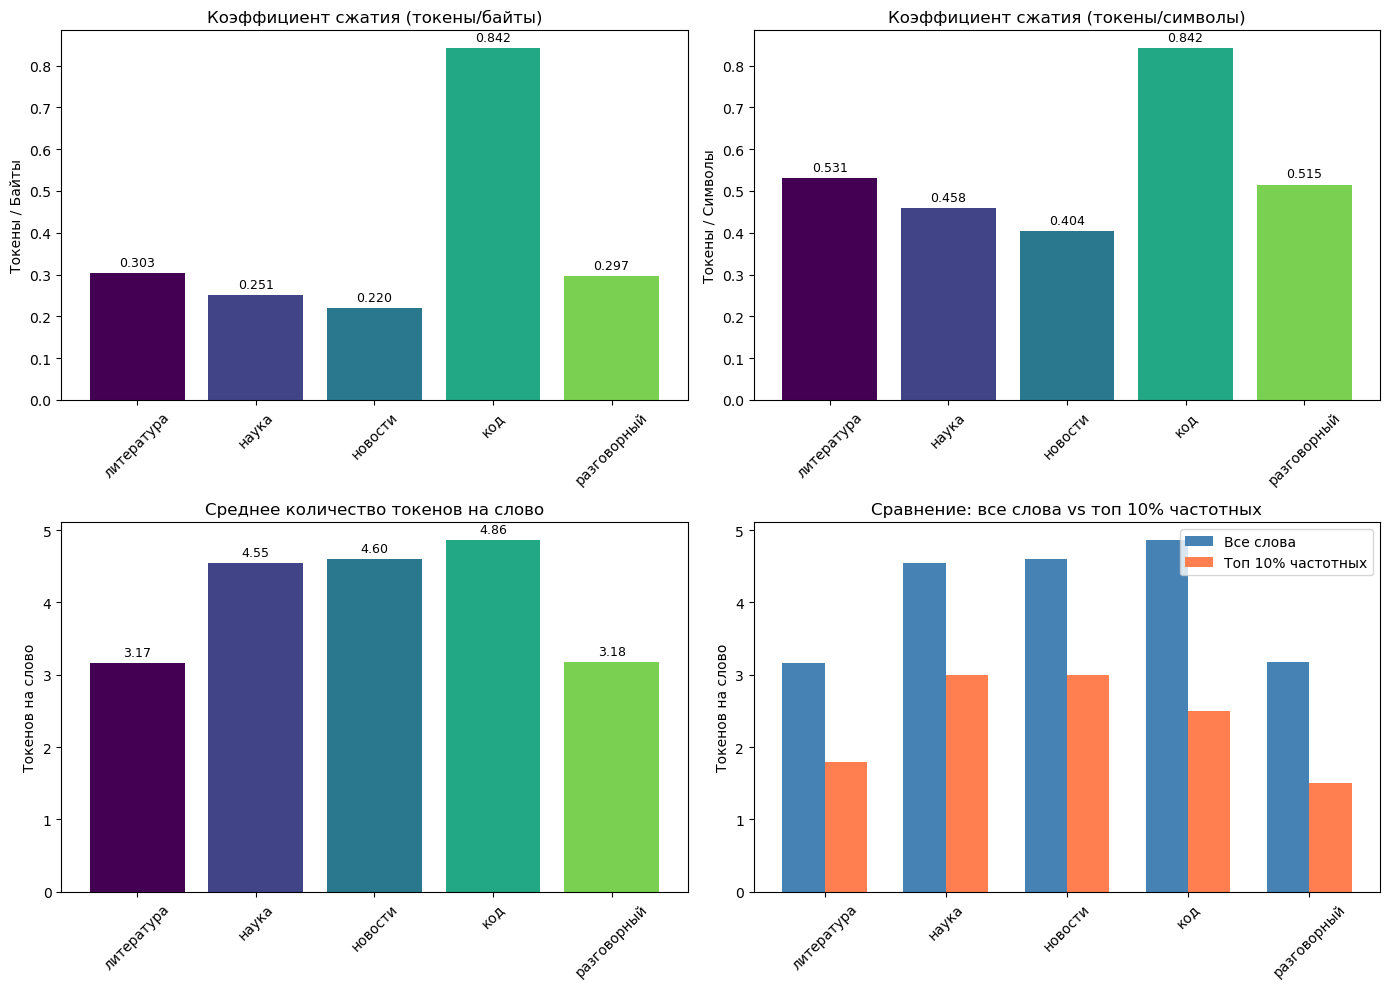

In [33]:
# Визуализация результатов по доменам
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

domains = list(domain_results.keys())
colors = plt.cm.viridis(np.linspace(0, 0.8, len(domains)))

# 1. Коэффициент сжатия (токены/байты)
ax1 = axes[0, 0]
compression_bytes = [domain_results[d]['compression_ratio_bytes'] for d in domains]
bars1 = ax1.bar(domains, compression_bytes, color=colors)
ax1.set_ylabel('Токены / Байты')
ax1.set_title('Коэффициент сжатия (токены/байты)')
ax1.tick_params(axis='x', rotation=45)
for bar, val in zip(bars1, compression_bytes):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Коэффициент сжатия (токены/символы)
ax2 = axes[0, 1]
compression_chars = [domain_results[d]['compression_ratio_chars'] for d in domains]
bars2 = ax2.bar(domains, compression_chars, color=colors)
ax2.set_ylabel('Токены / Символы')
ax2.set_title('Коэффициент сжатия (токены/символы)')
ax2.tick_params(axis='x', rotation=45)
for bar, val in zip(bars2, compression_chars):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Среднее токенов на слово
ax3 = axes[1, 0]
avg_tokens = [domain_results[d]['avg_tokens_per_word'] for d in domains]
bars3 = ax3.bar(domains, avg_tokens, color=colors)
ax3.set_ylabel('Токенов на слово')
ax3.set_title('Среднее количество токенов на слово')
ax3.tick_params(axis='x', rotation=45)
for bar, val in zip(bars3, avg_tokens):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=9)

# 4. Сравнение: все слова vs топ 10%
ax4 = axes[1, 1]
x = np.arange(len(domains))
width = 0.35
avg_all = [domain_results[d]['avg_tokens_per_word'] for d in domains]
avg_top = [domain_results[d]['avg_tokens_top_10_percent'] for d in domains]
bars4a = ax4.bar(x - width/2, avg_all, width, label='Все слова', color='steelblue')
bars4b = ax4.bar(x + width/2, avg_top, width, label='Топ 10% частотных', color='coral')
ax4.set_ylabel('Токенов на слово')
ax4.set_title('Сравнение: все слова vs топ 10% частотных')
ax4.set_xticks(x)
ax4.set_xticklabels(domains, rotation=45)
ax4.legend()

plt.tight_layout()
plt.savefig('domain_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [14]:
# Вывод об отличиях эффективности для разных доменов
print("\n" + "=" * 80)
print("ВЫВОДЫ ОБ ЭФФЕКТИВНОСТИ ДЛЯ РАЗНЫХ ДОМЕНОВ")
print("=" * 80)

# Находим лучший и худший домен
best_domain = min(domains, key=lambda d: domain_results[d]['compression_ratio_bytes'])
worst_domain = max(domains, key=lambda d: domain_results[d]['compression_ratio_bytes'])

print(f"""
Эффективность токенизатора существенно отличается для разных доменов:

1. ЛУЧШИЙ ДОМЕН: {best_domain.upper()}
   - Коэффициент сжатия: {domain_results[best_domain]['compression_ratio_bytes']:.4f} токенов/байт
   - Среднее токенов на слово: {domain_results[best_domain]['avg_tokens_per_word']:.2f}

2. ХУДШИЙ ДОМЕН: {worst_domain.upper()}
   - Коэффициент сжатия: {domain_results[worst_domain]['compression_ratio_bytes']:.4f} токенов/байт
   - Среднее токенов на слово: {domain_results[worst_domain]['avg_tokens_per_word']:.2f}

3. ПРИЧИНЫ РАЗЛИЧИЙ:
   - Код содержит много специальных символов и английских слов, которые могут быть
     недостаточно представлены в обучающем корпусе на русском языке
   - Литературные и разговорные тексты содержат более частотную лексику
   - Научные тексты используют специализированную терминологию
   - Частотные слова (топ 10%) токенизируются эффективнее, чем редкие слова

4. РЕКОМЕНДАЦИИ:
   - Для специализированных доменов рекомендуется дообучение токенизатора
   - Включение доменных текстов в обучающий корпус улучшает эффективность
""")


ВЫВОДЫ ОБ ЭФФЕКТИВНОСТИ ДЛЯ РАЗНЫХ ДОМЕНОВ

Эффективность токенизатора существенно отличается для разных доменов:

1. ЛУЧШИЙ ДОМЕН: НОВОСТИ
   - Коэффициент сжатия: 0.2203 токенов/байт
   - Среднее токенов на слово: 4.60

2. ХУДШИЙ ДОМЕН: КОД
   - Коэффициент сжатия: 0.8420 токенов/байт
   - Среднее токенов на слово: 4.86

3. ПРИЧИНЫ РАЗЛИЧИЙ:
   - Код содержит много специальных символов и английских слов, которые могут быть
     недостаточно представлены в обучающем корпусе на русском языке
   - Литературные и разговорные тексты содержат более частотную лексику
   - Научные тексты используют специализированную терминологию
   - Частотные слова (топ 10%) токенизируются эффективнее, чем редкие слова

4. РЕКОМЕНДАЦИИ:
   - Для специализированных доменов рекомендуется дообучение токенизатора
   - Включение доменных текстов в обучающий корпус улучшает эффективность



## 6. Кривая: Размер словаря vs Compression Ratio

In [15]:
# Обучаем токенизаторы с разными размерами словаря
vocab_sizes = [300, 500, 1000, 2000, 3000, 5000, 7000, 10000]
compression_ratios = []

# Объединяем все тестовые тексты
all_test_texts = []
for texts in test_corpora.values():
    all_test_texts.extend(texts)

for vocab_size in vocab_sizes:
    print(f"Обучение токенизатора с vocab_size={vocab_size}...")
    
    temp_tokenizer = BPETokenizer(vocab_size=vocab_size)
    temp_tokenizer.train(training_corpus, verbose=False)
    
    # Вычисляем compression ratio
    total_tokens = 0
    total_bytes = 0
    
    for text in all_test_texts:
        encoded = temp_tokenizer.encode(text)
        total_tokens += len(encoded)
        total_bytes += len(text.encode('utf-8'))
    
    ratio = total_tokens / total_bytes
    compression_ratios.append(ratio)
    print(f"  Compression ratio: {ratio:.4f}")

print("\nГотово!")

Обучение токенизатора с vocab_size=300...
  Compression ratio: 0.5619
Обучение токенизатора с vocab_size=500...
  Compression ratio: 0.4075
Обучение токенизатора с vocab_size=1000...
  Compression ratio: 0.3611
Обучение токенизатора с vocab_size=2000...
  Compression ratio: 0.3398
Обучение токенизатора с vocab_size=3000...
  Compression ratio: 0.3398
Обучение токенизатора с vocab_size=5000...
  Compression ratio: 0.3398
Обучение токенизатора с vocab_size=7000...
  Compression ratio: 0.3398
Обучение токенизатора с vocab_size=10000...
  Compression ratio: 0.3398

Готово!


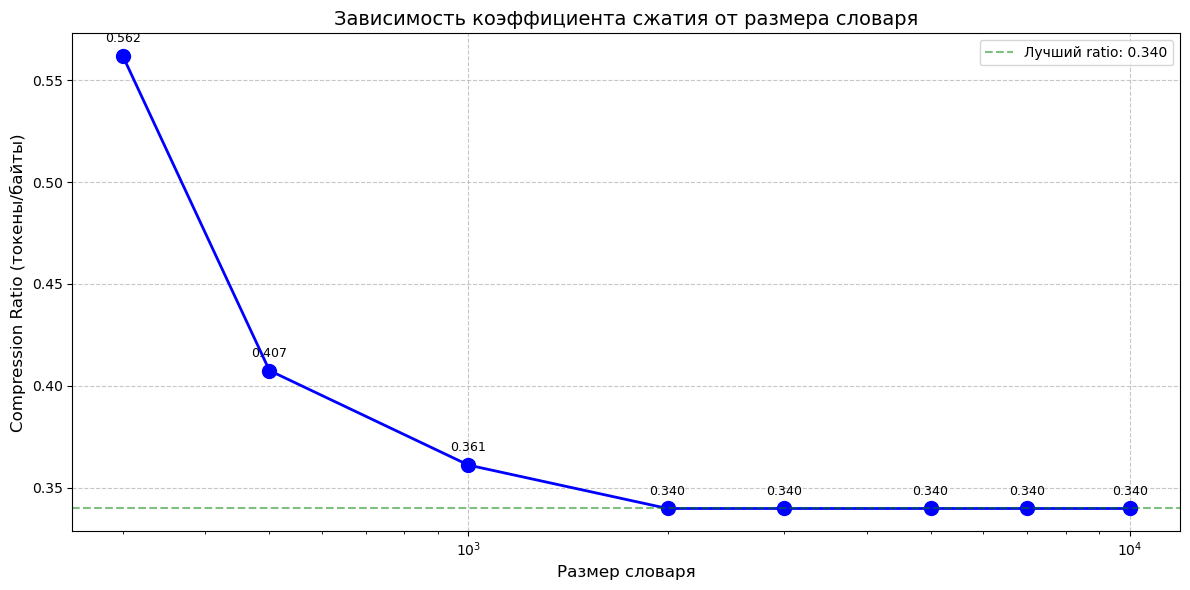

Результаты:
   При увеличении словаря с 300 до 10000:
   Compression ratio улучшился с 0.5619 до 0.3398
   Улучшение: 39.5%


In [34]:
# Построение графика
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(vocab_sizes, compression_ratios, 'bo-', linewidth=2, markersize=10)

# Добавляем значения на график
for x, y in zip(vocab_sizes, compression_ratios):
    ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                xytext=(0, 10), ha='center', fontsize=9)

ax.set_xlabel('Размер словаря', fontsize=12)
ax.set_ylabel('Compression Ratio (токены/байты)', fontsize=12)
ax.set_title('Зависимость коэффициента сжатия от размера словаря', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xscale('log')

# Добавляем аннотации
ax.axhline(y=min(compression_ratios), color='g', linestyle='--', alpha=0.5, 
           label=f'Лучший ratio: {min(compression_ratios):.3f}')

ax.legend()

plt.tight_layout()
plt.savefig('vocab_vs_compression.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Результаты:")
print(f"   При увеличении словаря с {vocab_sizes[0]} до {vocab_sizes[-1]}:")
print(f"   Compression ratio улучшился с {compression_ratios[0]:.4f} до {compression_ratios[-1]:.4f}")
print(f"   Улучшение: {(1 - compression_ratios[-1]/compression_ratios[0])*100:.1f}%")

## 7. Анализ на корпусе стихотворений Пушкина


In [ ]:
pushkin_corpus_path = "texts"  # папка с .txt файлами

def load_pushkin_corpus(path: str) -> List[str]:
    """
    Загрузка корпуса стихотворений Пушкина.
    """
    if not os.path.exists(path):
        print(f"Путь не найден: {path}")
        return None
    
    texts = []
    
    if os.path.isdir(path):
        txt_files = glob.glob(os.path.join(path, "*.txt"))
        
        txt_files += glob.glob(os.path.join(path, "**", "*.txt"), recursive=True)
        
        txt_files = list(set(txt_files))
        
        if not txt_files:
            print(f"В папке {path} не найдено .txt файлов")
            return None
        
        print(f"Найдено {len(txt_files)} .txt файлов")
        
        for txt_file in sorted(txt_files):
            try:
                with open(txt_file, 'r', encoding='utf-8') as f:
                    content = f.read().strip()
                    if content:
                        texts.append(content)
            except UnicodeDecodeError:
                # Пробуем другие кодировки
                try:
                    with open(txt_file, 'r', encoding='cp1251') as f:
                        content = f.read().strip()
                        if content:
                            texts.append(content)
                except Exception as e:
                    print(f"Ошибка чтения {txt_file}: {e}")
            except Exception as e:
                print(f"Ошибка чтения {txt_file}: {e}")
    
    elif path.endswith('.txt'):
        with open(path, 'r', encoding='utf-8') as f:
            content = f.read()
            poems = content.split('\n\n')
            texts = [p.strip() for p in poems if p.strip()]
            
    elif path.endswith('.xml'):
        import xml.etree.ElementTree as ET
        tree = ET.parse(path)
        root = tree.getroot()
        for elem in root.iter():
            if elem.text:
                texts.append(elem.text.strip())
                
    elif path.endswith('.json'):
        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)
            if isinstance(data, list):
                texts = [str(item) for item in data]
            elif isinstance(data, dict):
                texts = [str(v) for v in data.values()]
    
    if texts:
        print(f"Загружено {len(texts)} текстов, общий объём: {sum(len(t) for t in texts)} символов")
    
    return texts if texts else None

In [19]:
pushkin_texts = load_pushkin_corpus(pushkin_corpus_path)

print(f"Всего текстов в корпусе: {len(pushkin_texts)}")
print(f"Общее количество символов: {sum(len(t) for t in pushkin_texts)}")

Найдено 913 .txt файлов
Загружено 913 текстов, общий объём: 719934 символов
Всего текстов в корпусе: 913
Общее количество символов: 719934


In [20]:
def analyze_unused_tokens(tokenizer: BPETokenizer, texts: List[str]) -> Dict:
    """
    Анализ неиспользованных токенов при токенизации корпуса.
    
    Returns:
        Словарь с результатами анализа
    """
    # Собираем все использованные токены
    used_tokens = set()
    token_counts = Counter()
    
    for text in texts:
        encoded = tokenizer.encode(text)
        used_tokens.update(encoded)
        token_counts.update(encoded)
    
    # Все токены в словаре
    all_tokens = set(tokenizer.vocab.values())
    
    # Неиспользованные токены
    unused_tokens = all_tokens - used_tokens
    
    # Статистика
    total_vocab_size = len(all_tokens)
    used_count = len(used_tokens)
    unused_count = len(unused_tokens)
    unused_percent = (unused_count / total_vocab_size) * 100
    
    # Примеры неиспользованных токенов
    unused_examples = []
    for token_id in list(unused_tokens)[:20]:
        token_str = tokenizer.inverse_vocab.get(token_id, "<?>")
        if token_str not in tokenizer.special_tokens:
            unused_examples.append((token_id, repr(token_str)))
    
    return {
        'total_vocab_size': total_vocab_size,
        'used_tokens_count': used_count,
        'unused_tokens_count': unused_count,
        'unused_percent': unused_percent,
        'unused_token_ids': unused_tokens,
        'unused_examples': unused_examples,
        'token_frequency': token_counts,
    }

In [22]:
# Анализ неиспользованных токенов на корпусе Пушкина
pushkin_analysis = analyze_unused_tokens(tokenizer, pushkin_texts)

print("=" * 80)
print("АНАЛИЗ НЕИСПОЛЬЗОВАННЫХ ТОКЕНОВ НА КОРПУСЕ СТИХОТВОРЕНИЙ ПУШКИНА")
print("=" * 80)

print(f"""
  СТАТИСТИКА:

  Размер словаря токенизатора: {pushkin_analysis['total_vocab_size']}
  Использовано токенов: {pushkin_analysis['used_tokens_count']}
  НЕ использовано токенов: {pushkin_analysis['unused_tokens_count']}
  
  ═══════════════════════════════════════════════════
  ДОЛЯ НЕИСПОЛЬЗОВАННЫХ ТОКЕНОВ: {pushkin_analysis['unused_percent']:.2f}%
  ═══════════════════════════════════════════════════
""")

print("\nПримеры неиспользованных токенов:")
for token_id, token_repr in pushkin_analysis['unused_examples'][:15]:
    print(f"   ID {token_id}: {token_repr}")

АНАЛИЗ НЕИСПОЛЬЗОВАННЫХ ТОКЕНОВ НА КОРПУСЕ СТИХОТВОРЕНИЙ ПУШКИНА

  СТАТИСТИКА:

  Размер словаря токенизатора: 1842
  Использовано токенов: 956
  НЕ использовано токенов: 886
  
  ═══════════════════════════════════════════════════
  ДОЛЯ НЕИСПОЛЬЗОВАННЫХ ТОКЕНОВ: 48.10%
  ═══════════════════════════════════════════════════


Примеры неиспользованных токенов:
   ID 5: '\x00'
   ID 6: '\x01'
   ID 7: '\x02'
   ID 8: '\x03'
   ID 9: '\x04'
   ID 10: '\x05'
   ID 11: '\x06'
   ID 12: '\x07'
   ID 13: '\x08'
   ID 14: '\t'
   ID 16: '\x0b'
   ID 17: '\x0c'
   ID 18: '\r'
   ID 19: '\x0e'
   ID 20: '\x0f'


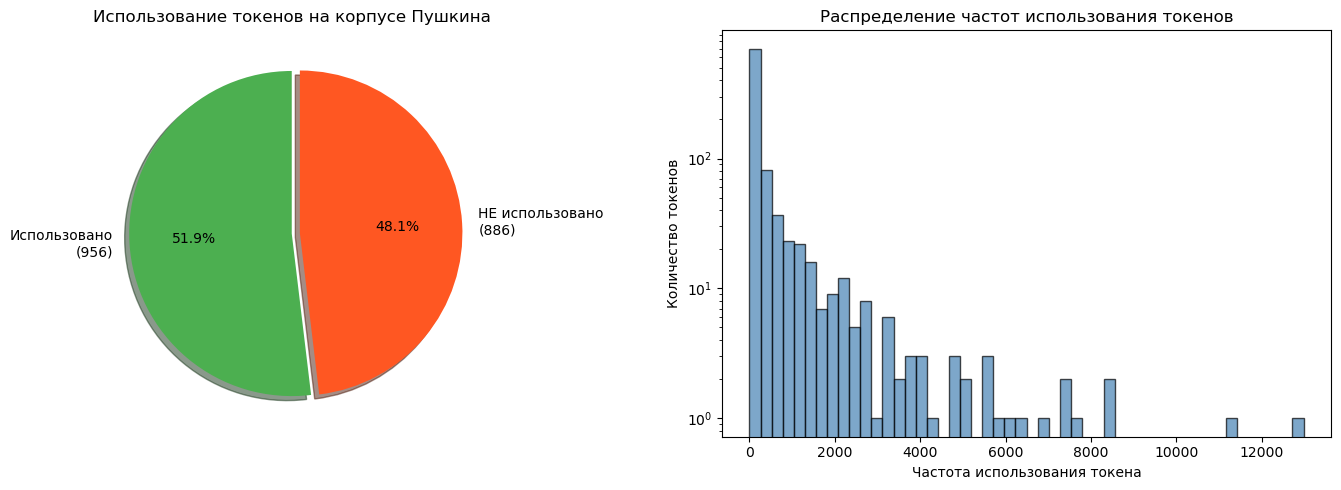

In [23]:
# Визуализация распределения использования токенов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Круговая диаграмма использованных/неиспользованных
ax1 = axes[0]
sizes = [pushkin_analysis['used_tokens_count'], pushkin_analysis['unused_tokens_count']]
labels = [f"Использовано\n({pushkin_analysis['used_tokens_count']})", 
          f"НЕ использовано\n({pushkin_analysis['unused_tokens_count']})"]
colors = ['#4CAF50', '#FF5722']
explode = (0, 0.05)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Использование токенов на корпусе Пушкина', fontsize=12)

# 2. Распределение частот токенов
ax2 = axes[1]
frequencies = list(pushkin_analysis['token_frequency'].values())
ax2.hist(frequencies, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Частота использования токена')
ax2.set_ylabel('Количество токенов')
ax2.set_title('Распределение частот использования токенов')
ax2.set_yscale('log')

plt.tight_layout()
plt.savefig('pushkin_token_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [24]:
# Дополнительный анализ корпуса Пушкина
pushkin_tokenization_results = analyze_tokenization(tokenizer, pushkin_texts, "Пушкин")

print("\n" + "=" * 80)
print("ЭФФЕКТИВНОСТЬ ТОКЕНИЗАЦИИ НА КОРПУСЕ ПУШКИНА")
print("=" * 80)

print(f"""
МЕТРИКИ ТОКЕНИЗАЦИИ:

  Всего токенов: {pushkin_tokenization_results['total_tokens']}
  Всего байт: {pushkin_tokenization_results['total_bytes']}
  Всего символов: {pushkin_tokenization_results['total_chars']}
  Всего слов: {pushkin_tokenization_results['total_words']}

  Коэффициент сжатия (токены/байты): {pushkin_tokenization_results['compression_ratio_bytes']:.4f}
  Коэффициент сжатия (токены/символы): {pushkin_tokenization_results['compression_ratio_chars']:.4f}
  Среднее токенов на слово: {pushkin_tokenization_results['avg_tokens_per_word']:.2f}
  Среднее токенов на слово (топ 10%): {pushkin_tokenization_results['avg_tokens_top_10_percent']:.2f}
""")


ЭФФЕКТИВНОСТЬ ТОКЕНИЗАЦИИ НА КОРПУСЕ ПУШКИНА

МЕТРИКИ ТОКЕНИЗАЦИИ:

  Всего токенов: 433952
  Всего байт: 1272964
  Всего символов: 719934
  Всего слов: 115159

  Коэффициент сжатия (токены/байты): 0.3409
  Коэффициент сжатия (токены/символы): 0.6028
  Среднее токенов на слово: 3.38
  Среднее токенов на слово (топ 10%): 3.70



## 8. Итоговая сводка результатов

In [35]:
print("\n" + "=" * 80)
print("ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ")
print("=" * 80)

print(f"""
1. ТОКЕНИЗАТОР
   ─────────────────────────────────────────────────────────────────────────────
     Тип: Byte Pair Encoding
     Паттерн претокенизации: адаптирован из GPT-4 (cl100k_base)
     Специальные токены: {', '.join(tokenizer.special_tokens)}
     Размер словаря: {tokenizer.get_vocab_size()}

2. КОЭФФИЦИЕНТЫ СЖАТИЯ ПО ДОМЕНАМ
   ─────────────────────────────────────────────────────────────────────────────""")

for domain in domains:
    r = domain_results[domain]
    print(f"     {domain:12s}: {r['compression_ratio_bytes']:.4f} токенов/байт, {r['avg_tokens_per_word']:.2f} токенов/слово")

print(f"""
3. ВЛИЯНИЕ РАЗМЕРА СЛОВАРЯ НА СЖАТИЕ
   ─────────────────────────────────────────────────────────────────────────────
     При vocab_size={vocab_sizes[0]}: compression ratio = {compression_ratios[0]:.4f}
     При vocab_size={vocab_sizes[-1]}: compression ratio = {compression_ratios[-1]:.4f}
     Улучшение при увеличении словаря: {(1 - compression_ratios[-1]/compression_ratios[0])*100:.1f}%

4. АНАЛИЗ КОРПУСА ПУШКИНА
   ─────────────────────────────────────────────────────────────────────────────
     Размер словаря: {pushkin_analysis['total_vocab_size']}
     Использовано токенов: {pushkin_analysis['used_tokens_count']} ({100 - pushkin_analysis['unused_percent']:.1f}%)
     НЕ использовано токенов: {pushkin_analysis['unused_tokens_count']} ({pushkin_analysis['unused_percent']:.1f}%)
     Коэффициент сжатия: {pushkin_tokenization_results['compression_ratio_bytes']:.4f} токенов/байт

5. ВЫВОДЫ
   ─────────────────────────────────────────────────────────────────────────────
     Эффективность токенизатора существенно различается для разных доменов
     Увеличение размера словаря улучшает коэффициент сжатия
     Значительная часть словаря не используется на специфических корпусах
     Частотные слова токенизируются эффективнее редких
""")


ИТОГОВАЯ СВОДКА РЕЗУЛЬТАТОВ

1. ТОКЕНИЗАТОР
   ─────────────────────────────────────────────────────────────────────────────
     Тип: Byte Pair Encoding
     Паттерн претокенизации: адаптирован из GPT-4 (cl100k_base)
     Специальные токены: <PAD>, <UNK>, <BOS>, <EOS>, <MASK>
     Размер словаря: 1842

2. КОЭФФИЦИЕНТЫ СЖАТИЯ ПО ДОМЕНАМ
   ─────────────────────────────────────────────────────────────────────────────
     литература  : 0.3031 токенов/байт, 3.17 токенов/слово
     наука       : 0.2506 токенов/байт, 4.55 токенов/слово
     новости     : 0.2203 токенов/байт, 4.60 токенов/слово
     код         : 0.8420 токенов/байт, 4.86 токенов/слово
     разговорный : 0.2970 токенов/байт, 3.18 токенов/слово

3. ВЛИЯНИЕ РАЗМЕРА СЛОВАРЯ НА СЖАТИЕ
   ─────────────────────────────────────────────────────────────────────────────
     При vocab_size=300: compression ratio = 0.5619
     При vocab_size=10000: compression ratio = 0.3398
     Улучшение при увеличении словаря: 39.5%

4. АНАЛИЗ КОР

In [26]:
tokenizer.save("bpe_tokenizer.json")
print("Токенизатор сохранён в файл 'bpe_tokenizer.json'")

Токенизатор сохранён в файл 'bpe_tokenizer.json'


Пример использования

In [36]:
example_text = "Я помню чудное мгновенье"

print(f"Текст: '{example_text}'")
print(f"Байты: {list(example_text.encode('utf-8'))}")
print(f"\nТокенизация:")

encoded = tokenizer.encode(example_text)
print(f"  Token IDs: {encoded}")
print(f"  Tokens: {[tokenizer.inverse_vocab[t] for t in encoded]}")
print(f"  Количество токенов: {len(encoded)}")
print(f"  Декодировано: '{tokenizer.decode(encoded)}'")

Текст: 'Я помню чудное мгновенье'
Байты: [208, 175, 32, 208, 191, 208, 190, 208, 188, 208, 189, 209, 142, 32, 209, 135, 209, 131, 208, 180, 208, 189, 208, 190, 208, 181, 32, 208, 188, 208, 179, 208, 189, 208, 190, 208, 178, 208, 181, 208, 189, 209, 140, 208, 181]

Токенизация:
  Token IDs: [213, 180, 687, 266, 309, 395, 422, 605, 302, 312, 266, 295, 595, 263]
  Tokens: ['Ð', '¯', ' Ð¿Ð¾Ð¼', 'Ð½', 'Ñ\x8e', ' Ñ\x87', 'Ñ\x83Ð´', 'Ð½Ð¾Ðµ', ' Ð¼', 'Ð³', 'Ð½', 'Ð¾Ð²', 'ÐµÐ½Ñ\x8c', 'Ðµ']
  Количество токенов: 14
  Декодировано: 'Я помню чудное мгновенье'
